In [12]:
import sys
import os


project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

from src.data_loader import load_stint
from src.degradation_model import DegradationModel
from src.strategy_sim import run_strategy_sim



In [14]:
df = load_stint("../data/sample_stint.csv")



In [15]:
model = DegradationModel()
model.fit(df)


In [16]:
X = df[["lap", "tyre_temp"]]
y = df["lap_time"]


In [17]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

poly_model = Pipeline([
    ("poly", PolynomialFeatures(degree=2)),
    ("lin", LinearRegression())
])


In [18]:
poly_model.fit(X, y)

,steps,"[('poly', ...), ('lin', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,True
,order,'C'
,fit_intercept,True
,copy_X,True
,tol,1e-06


In [19]:
prediction_cache = {}

def get_cached_prediction(lap, tyre_temp):
    key = (lap, tyre_temp)
    if key not in prediction_cache:
        df = pd.DataFrame({"lap": [lap], "tyre_temp": [tyre_temp]})
        prediction_cache[key] = float(poly_model.predict(df)[0])
    return prediction_cache[key]

In [20]:
#Tyre Compound Stats


tyre_compounds = {
    "soft": {
        "base_lap_time":81.1,
        "degredation_per_lap":0.07,
        "temp_increase_per_lap":1.1,
        "ideal_temp":100,
        "warmup_lap": 1
    },
    "medium": {
        "base_lap_time":81.4,
        "degredation_per_lap":0.045,
        "temp_increase_per_lap":0.9,
        "ideal_temp":105,
        "warmup_lap": 2
    },
    "hard": {
        "base_lap_time":82,
        "degredation_per_lap":0.03,
        "temp_increase_per_lap":0.7,
        "ideal_temp":110,
        "warmup_lap": 3
    },

    
}

In [ ]:

# One-Stop strategy

import pandas as pd
import numpy as np

race_laps = 58
pit_loss = 21.93  
starting_fuel = 100     
fuel_burn_per_lap = 1.7  
fuel_penalty_per_kg = 0.035


def generate_two_compound_stint(pit_lap, compound1, compound2, fuel): 
   """
    Simulate a Two-compound race stint with one pit stops.

    Parameters
    ----------
    pit_lap : int
        Pit stop lap.
    compound1, compound2: str
        Tyre compounds for each stint ('soft', 'medium', 'hard').
    fuel : float
        Starting fuel weight in kilograms.

    Returns
    -------
    pd.DataFrame
        Columns:
            'lap' : Lap number (1..race distance)
            'lap_time' : Predicted lap time
            'tyre_temp' : Tyre carcass temperature
            'compound' : Compound used on that lap
   """
   compound_stats1 = tyre_compounds[compound1]
   compound_stats2 = tyre_compounds[compound2]
   compounds_used = []
   tyre_temps = []   
   laps = []
   stint_lap = 0

    # Fuel Stats
   fuel_weight = fuel                     
   fuel_burn_per_lap = 1.8                
   fuel_penalty_per_kg = 0.02       

   for lap in range(1, race_laps + 1):

        stint_lap += 1

        # Rule to make sure correct compound is used and returns the compound used
        if lap <= pit_lap:
           stats = compound_stats1
        else :
          stats = compound_stats2

        if lap < pit_lap:
            stats = compound_stats1
            compound = compound1
        elif lap > pit_lap:
            stats = compound_stats2
            compound = compound2

       # Tyre temp affect on time
        tyre_temp = 80 + stint_lap * stats["temp_increase_per_lap"]  
        tyre_temp = min(110, tyre_temp) 
        if tyre_temp >= 105:
           predicted += 0.3 

        tyre_temps.append(tyre_temp)

        
        predicted = get_cached_prediction(stint_lap, tyre_temp)
        # give a time penalty or gain depending on compound used
        predicted += stats["base_lap_time"] - 81.3
        # Compound based Degredation changes
        degradation = stats["degredation_per_lap"] * stint_lap
        predicted += degradation
        # Track Evolution affecting average lap times
        track_evolution = lap * 0.02
        predicted -= track_evolution
        # Fuel penalty using previous stats
        fuel_penalty = fuel_weight * fuel_penalty_per_kg
        predicted += fuel_penalty
        predicted = max(predicted, stats["base_lap_time"] - 0.2)
       
    
       # Warmup-laps
        if stint_lap == 1:         
           predicted += 1.4       
        elif stint_lap == 2:       
           predicted += 0.5
        elif stint_lap == 3:
           predicted += 0.15

        
       # Pit time loss and Tyre age reseting
        if lap == pit_lap:
            predicted += pit_loss
            stint_lap = 0

      


        laps.append(predicted)
        compounds_used.append(compound)
   return pd.DataFrame({"lap": range(1, race_laps + 1),"lap_time": laps,"tyre_temp": tyre_temps,"compound": compounds_used})



In [ ]:
# Two-Stop Strategy
def generate_three_compound_stint(pit_lap1, pit_lap2, compound1, compound2, compound3, fuel):
    
    """
    Simulate a 3-compound race stint with two pit stops.

    Parameters
    ----------
    pit_lap1 : int
        First pit stop lap.
    pit_lap2 : int
        Second pit stop lap.
    compound1, compound2, compound3 : str
        Tyre compounds for each stint ('soft', 'medium', 'hard').
    fuel : float
        Starting fuel weight in kilograms.

    Returns
    -------
    pd.DataFrame
        Columns:
            'lap' : Lap number (1..race distance)
            'lap_time' : Predicted lap time
            'tyre_temp' : Tyre carcass temperature
            'compound' : Compound used on that lap
    """

    compound_stats1 = tyre_compounds[compound1]
    compound_stats2 = tyre_compounds[compound2]
    compound_stats3 = tyre_compounds[compound3]
    compounds_used = []
    tyre_temps = []   
    laps = []
    stint_lap = 0

    # Fuel Stats
    fuel_weight = fuel                     
    fuel_burn_per_lap = 1.8                
    fuel_penalty_per_kg = 0.02       

    for lap in range(1, race_laps + 1):

        stint_lap += 1

        # Rule to make sure correct compound is used and returns the compound used
        if lap <= pit_lap1:
           stats = compound_stats1
        elif lap <= pit_lap2:
           stats = compound_stats2
        else:
           stats = compound_stats3
         
        if lap < pit_lap1:
            stats = compound_stats1
            compound = compound1
        elif lap < pit_lap2:
            stats = compound_stats2
            compound = compound2
        else:
            stats = compound_stats3
            compound = compound3



       # Tyre temp affect on time
        tyre_temp = 80 + stint_lap * stats["temp_increase_per_lap"]  
        tyre_temp = min(110, tyre_temp) 
        if tyre_temp >= 105:
           predicted += 0.3 

        tyre_temps.append(tyre_temp)

        
        predicted = get_cached_prediction(stint_lap, tyre_temp)
        # give a time penalty or gain depending on compound used
        predicted += stats["base_lap_time"] - 81.3
        # Compound based Degredation changes
        degradation = stats["degredation_per_lap"] * stint_lap
        predicted += degradation
        # Track Evolution affecting average lap times
        track_evolution = lap * 0.02
        predicted -= track_evolution
        # Fuel penalty using previous stats
        fuel_penalty = fuel_weight * fuel_penalty_per_kg
        predicted += fuel_penalty
        predicted = max(predicted, stats["base_lap_time"] - 0.2)
       
        # Warmup-laps
        if stint_lap == 1:         
           predicted += 1.4       
        elif stint_lap == 2:       
           predicted += 0.5
        elif stint_lap == 3:
           predicted += 0.15

        
       # Pit time loss and Tyre age reseting
        
        if lap == pit_lap1:
           predicted += pit_loss
           stint_lap = 0
        elif lap == pit_lap2:
            predicted += pit_loss
            stint_lap = 0
            


      


        laps.append(predicted)
        compounds_used.append(compound)
        
    return pd.DataFrame({"lap": range(1, race_laps + 1),"lap_time": laps,"tyre_temp": tyre_temps,"compound": compounds_used})


In [23]:
# Stratergy Comparison


import numpy as np
strategy_20 = generate_two_compound_stint(25, "soft", "medium", 100)
strategy_30 = generate_two_compound_stint(40, "hard", "soft", 100)

def simulate_race_total(strategy_df, noise_std=0.3):

    noise = np.random.normal(0, noise_std, len(strategy_df))
    return float((strategy_df["lap_time"] + noise).sum())

N = 5000
wins_20 = 0
diffs = []

for _ in range(N):
    t20 = simulate_race_total(strategy_20)
    t30 = simulate_race_total(strategy_30)
    diffs.append(t20 - t30)
    if t20 < t30:
        wins_20 += 1

prob_20_wins = wins_20 / N
prob_20_wins


1.0

In [24]:
mean_diff = np.mean(diffs)
std_diff = np.std(diffs)

print(f"Probability pit at lap 25 beats pit at lap 40: {prob_20_wins*100:.1f}%")
print(f"Average time difference (pit20 - pit30): {mean_diff:.3f} s")
print(f"Std dev of difference: {std_diff:.3f} s")


Probability pit at lap 25 beats pit at lap 40: 100.0%
Average time difference (pit20 - pit30): -19.947 s
Std dev of difference: 3.264 s


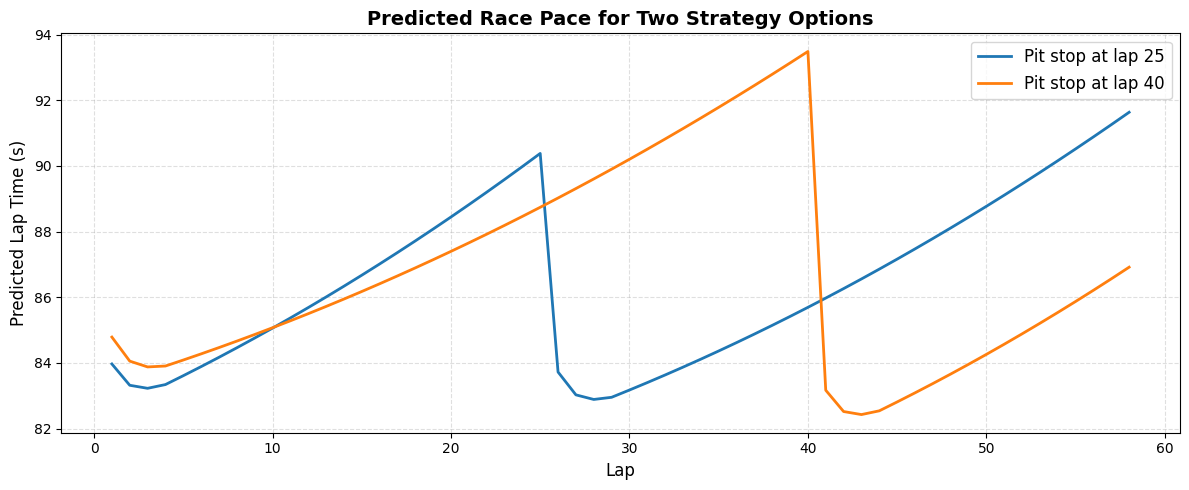

In [25]:
# Lap time graph for these two Strategies

plt.figure(figsize=(12, 5))
plt.plot(strategy_20["lap"], strategy_20["lap_time"],label="Pit stop at lap 25", linewidth=2)
plt.plot(strategy_30["lap"], strategy_30["lap_time"],label="Pit stop at lap 40", linewidth=2)
plt.xlabel("Lap", fontsize=12)
plt.ylabel("Predicted Lap Time (s)", fontsize=12)
plt.title("Predicted Race Pace for Two Strategy Options",fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



In [26]:
# Generation Of a Sample Of Some Strategies
strategy_1 = generate_two_compound_stint(25, "soft", "medium", 100)
strategy_2 = generate_two_compound_stint(30, "medium", "medium", 100)
strategy_3 = generate_two_compound_stint(40, "hard", "soft", 100)
strategy_4 = generate_three_compound_stint(20, 50, "soft", "medium", "soft", 100)

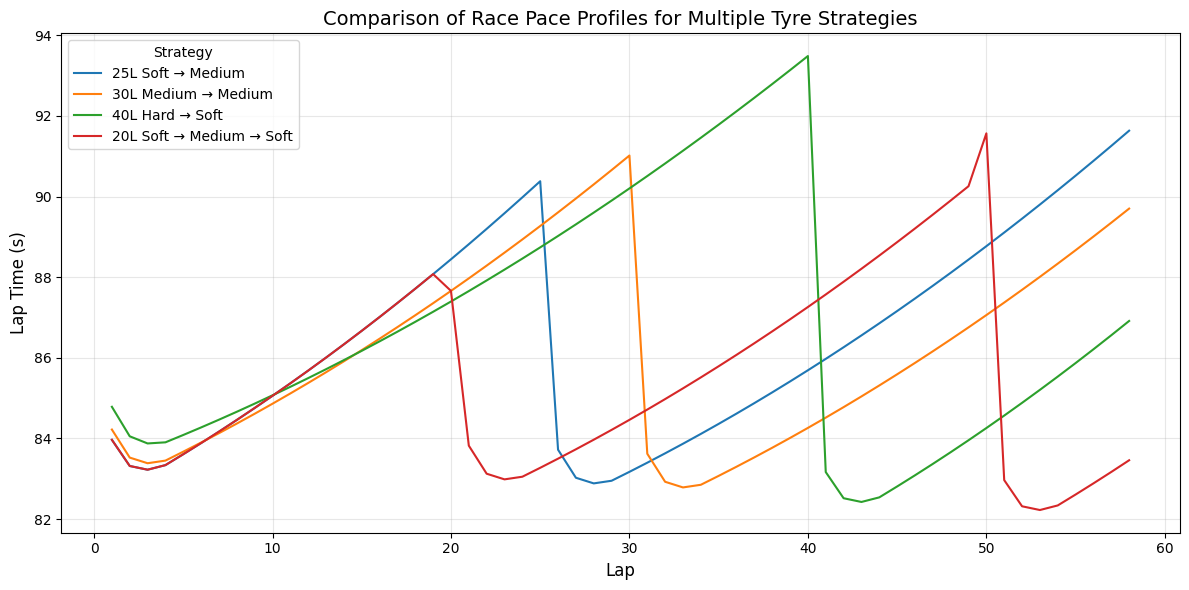

In [27]:
plt.figure(figsize=(12, 6))

plt.plot(strategy_1["lap"], strategy_1["lap_time"], label="25L Soft → Medium")
plt.plot(strategy_2["lap"], strategy_2["lap_time"], label="30L Medium → Medium")
plt.plot(strategy_3["lap"], strategy_3["lap_time"], label="40L Hard → Soft")
plt.plot(strategy_4["lap"], strategy_4["lap_time"], label="20L Soft → Medium → Soft")

plt.xlabel("Lap", fontsize=12)
plt.ylabel("Lap Time (s)", fontsize=12)
plt.title("Comparison of Race Pace Profiles for Multiple Tyre Strategies", fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend(title="Strategy", fontsize=10)

plt.tight_layout()
plt.show()



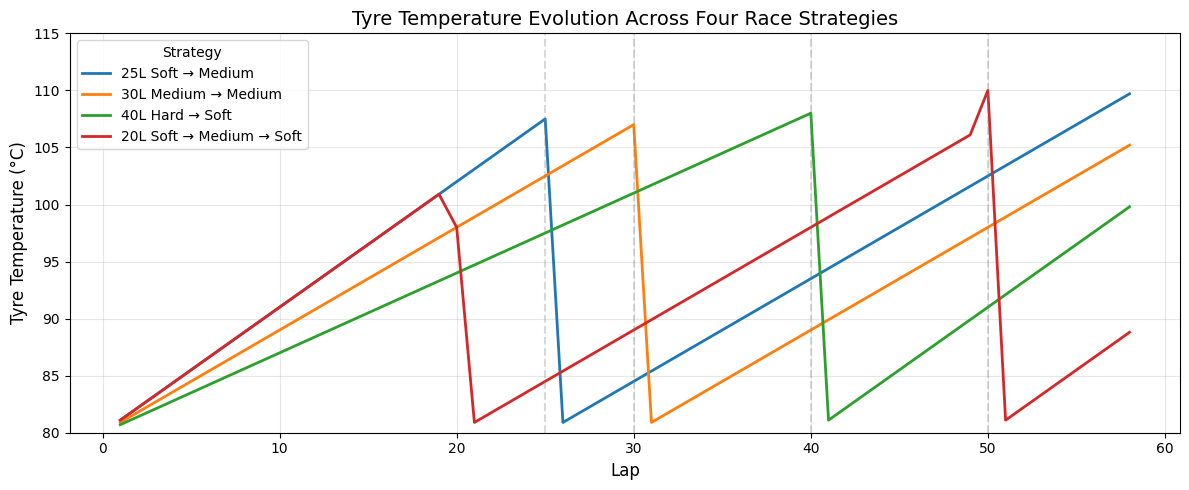

In [28]:
# Very Simple Tyre Temp Graph

plt.figure(figsize=(12, 5))

plt.plot(strategy_1["lap"], strategy_1["tyre_temp"], label="25L Soft → Medium", linewidth=2)
plt.plot(strategy_2["lap"], strategy_2["tyre_temp"], label="30L Medium → Medium", linewidth=2)
plt.plot(strategy_3["lap"], strategy_3["tyre_temp"], label="40L Hard → Soft", linewidth=2)
plt.plot(strategy_4["lap"], strategy_4["tyre_temp"], label="20L Soft → Medium → Soft", linewidth=2)

# Mark pit stops
for lap in [25, 30, 40, 50]:
    plt.axvline(lap, color="gray", linestyle="--", alpha=0.3)

plt.xlabel("Lap", fontsize=12)
plt.ylabel("Tyre Temperature (°C)", fontsize=12)
plt.title("Tyre Temperature Evolution Across Four Race Strategies", fontsize=14)

plt.grid(True, alpha=0.3)
plt.legend(title="Strategy", fontsize=10)
plt.ylim(80, 115)

plt.tight_layout()
plt.show()


In [29]:
def total_race_time(strategy_df):
    return float(strategy_df["lap_time"].sum())

In [30]:
def evaluate_three_stint_strategy(pit_lap1, pit_lap2, compound1, compound2, compound3,fuel):
  
    strategy_df = generate_three_compound_stint(pit_lap1, pit_lap2, compound1, compound2, compound3, fuel)
    total_time = total_race_time(strategy_df)
    return total_time, strategy_df


In [31]:
def evaluate_two_stint_strategy(pit_lap1, compound1, compound2, fuel):
  
    strategy_df = generate_two_compound_stint(pit_lap1, compound1, compound2, fuel)
    total_time = total_race_time(strategy_df)
    return total_time, strategy_df

In [32]:
# Tool to Find the Most Optimal Two-Stop Strategy

import itertools

def optimise_three_stint_strategies(
    fuel=100,
    compounds=("soft", "medium", "hard"),
    min_stint_len=8,
    final_min_len=5
):
    
   # Brute-force optimiser for three-stint race strategies.
    

    global race_laps  

    best_time = None
    best_params = None
    best_df = None
    all_results = []

    
    # Build all valid compound triples using a least two diffrent compounds+
    
   
    valid_combos = []
    for c1 in compounds:
        for c2 in compounds:
            for c3 in compounds:
                if len({c1, c2, c3}) >= 2:
                    valid_combos.append((c1, c2, c3))

    # Evaluate all strategies 
    for c1, c2, c3 in valid_combos:

        for pit_lap1 in range(12, 30):

            first_possible_pit2 = pit_lap1 + min_stint_len
            last_possible_pit2 = race_laps - final_min_len

            for pit_lap2 in range(first_possible_pit2, min(last_possible_pit2, 50)):

                total_time, df = evaluate_three_stint_strategy(
                    pit_lap1, pit_lap2, c1, c2, c3, fuel
                )

                result = {
                    "total_time": total_time,
                    "pit_lap1": pit_lap1,
                    "pit_lap2": pit_lap2,
                    "compound1": c1,
                    "compound2": c2,
                    "compound3": c3,
                }

                all_results.append(result)

                if (best_time is None) or (total_time < best_time):
                    best_time = total_time
                    best_params = result
                    best_df = df

    return {
        "best_time": best_time,
        "best_params": best_params,
        "best_strategy_df": best_df,
        "all_results": all_results,
    }


In [33]:
# Tool To Find the Most Optimal One-Stop Strategy

import itertools
def optimise_two_stint_strategies(
    fuel=100,
    compounds=("soft", "medium", "hard"),
    min_stint_len=8,
    final_min_len=5
):
    """
    Brute-force optimiser for one-stop race strategies.

    Evaluates all valid combinations of:
    - two tyre compounds (at least one must be different)
    - pit stop between laps 10 and 55
    - minimum stint length requirements

    Parameters
    ----------
    fuel : float
        Starting fuel weight (kg)
    compounds : tuple
        Tyre compounds available
    min_stint_len : int
        Minimum laps required before and after the stop
    final_min_len : int
        Minimum laps in the final stint

    Returns
    -------
    dict with:
        - best_time
        - best_params
        - best_strategy_df
        - all_results (list of all strategies)
    """

    global race_laps

    best_time = None
    best_params = None
    best_df = None
    all_results = []

  # Build all valid compound triples using a least two diffrent compounds+
   
    valid_combos = []
    for c1 in compounds:
        for c2 in compounds:
            if (c1 != c2):  
                valid_combos.append((c1, c2))  

    # Evaluate all strategies
    for c1, c2 in valid_combos:

        for pit_lap1 in range(10, 55):

            # Stint length requirements
            first_stint = pit_lap1
            second_stint = race_laps - pit_lap1

            if first_stint < min_stint_len:
                continue
            if second_stint < final_min_len:
                continue

            # Evaluate strategy
            total_time, df = evaluate_two_stint_strategy(
                pit_lap1, c1, c2, fuel
            )

            result = {
                "total_time": total_time,
                "pit_lap1": pit_lap1,
                "compound1": c1,
                "compound2": c2,
            }

            all_results.append(result)

            # Update optimal result
            if (best_time is None) or (total_time < best_time):
                best_time = total_time
                best_params = result
                best_df = df

    return {
        "best_time": best_time,
        "best_params": best_params,
        "best_strategy_df": best_df,
        "all_results": all_results,
    }


In [34]:
opt_result2 = optimise_three_stint_strategies(fuel=100)
print("two stop")
opt_result2["best_time"]
opt_result2["best_params"]

two stop


{'total_time': 4916.278571269921,
 'pit_lap1': 18,
 'pit_lap2': 38,
 'compound1': 'soft',
 'compound2': 'medium',
 'compound3': 'medium'}

In [35]:
opt_result1 = optimise_two_stint_strategies(fuel=100)

print("One Stop")
opt_result1["best_time"]
opt_result1["best_params"]

One Stop


{'total_time': 4996.013397962674,
 'pit_lap1': 28,
 'compound1': 'medium',
 'compound2': 'hard'}

In [36]:
best_df1 = opt_result1["best_strategy_df"].copy()
best_df2 = opt_result2["best_strategy_df"].copy()

best_df1["lap"] = range(1, len(best_df1) + 1)
best_df2["lap"] = range(1, len(best_df2) + 1)


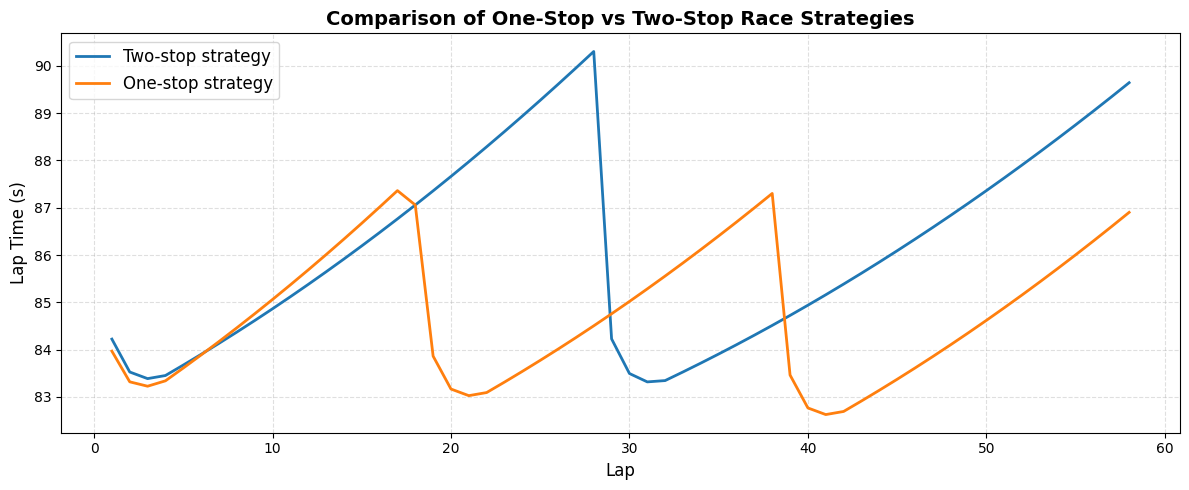

In [37]:
# Comparison of the Two Optimal Strategies

plt.figure(figsize=(12, 5))
plt.plot(best_df1["lap"], best_df1["lap_time"],label="Two-stop strategy", linewidth=2)
plt.plot(best_df2["lap"], best_df2["lap_time"],label="One-stop strategy", linewidth=2)
plt.xlabel("Lap", fontsize=12)
plt.ylabel("Lap Time (s)", fontsize=12)
plt.title("Comparison of One-Stop vs Two-Stop Race Strategies",fontsize=14, fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



In [38]:
"""
The fastest stratergy using this data would be the Two stop where you start on softs before pitting first at lap 18 on to mediums and then again pitting on to mediums at lap 38.
This is fastest as it maximises the positives of each compound and maximises the time spent on fresh tyres. 
For example the one stop starts on mediums for 28 laps before pitting onto hards this causes the two-stopper to gain about 3 seconds to 4 seconds a lap from lap 18 to 28 offsetting the time lost in the first stop and gaining ~10s
One key problem the model ignores is traffic and dirty air causing probelms as while the two stop is quicker on paper it may put the driver into traffic or DRS trains leading to lost time and added wear on tyres due to higher temps.
This means the one stop may be the better strategy for a leading car as it reduces externalities such as traffic, slow stops and saftey cars.
"""


'\nThe fastest stratergy using this data would be the Two stop where you start on softs before pitting first at lap 18 on to mediums and then again pitting on to mediums at lap 38.\nThis is fastest as it maximises the positives of each compound and maximises the time spent on fresh tyres. \nFor example the one stop starts on mediums for 28 laps before pitting onto hards this causes the two-stopper to gain about 3 seconds to 4 seconds a lap from lap 18 to 28 offsetting the time lost in the first stop and gaining ~10s\nOne key problem the model ignores is traffic and dirty air causing probelms as while the two stop is quicker on paper it may put the driver into traffic or DRS trains leading to lost time and added wear on tyres due to higher temps.\nThis means the one stop may be the better strategy for a leading car as it reduces externalities such as traffic, slow stops and saftey cars.\n'